In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   2697      0 --:--:-- --:--:-- --:--:--  2697
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Dataset

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/"labels"
path_img = path/"images"

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009690.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02460.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01950.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02280_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08147_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07975_P.png')]

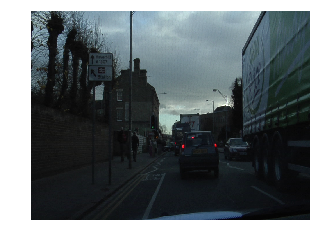

In [10]:
image_file = fnames[0]
image = open_image(image_file)
image.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x: path_lbl/f"{x.stem}_P{x.suffix}"

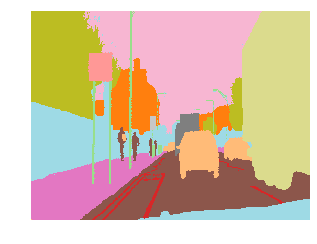

In [12]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(5, 5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 27, 27, 27],
          [26, 26, 26,  ..., 27, 27, 27],
          [26, 26, 26,  ..., 27, 27, 27],
          ...,
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30]]]))

In [16]:
codes = np.loadtxt(path/"codes.txt", dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [18]:
size = src_size // 2

free_memory = gpu_mem_get_free_no_cache()
if free_memory > 8200:
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free_memory}MB of GPU RAM free.")

using bs=8, have 11430MB of GPU RAM free.


In [0]:
src = (SegmentationItemList.from_folder(path_img).split_by_fname_file("../valid.txt").label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(tfms=get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

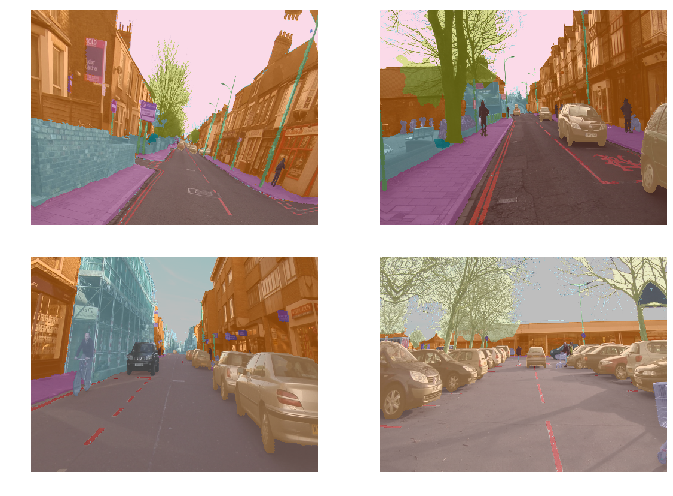

In [22]:
data.show_batch(2, figsize=(10, 7))

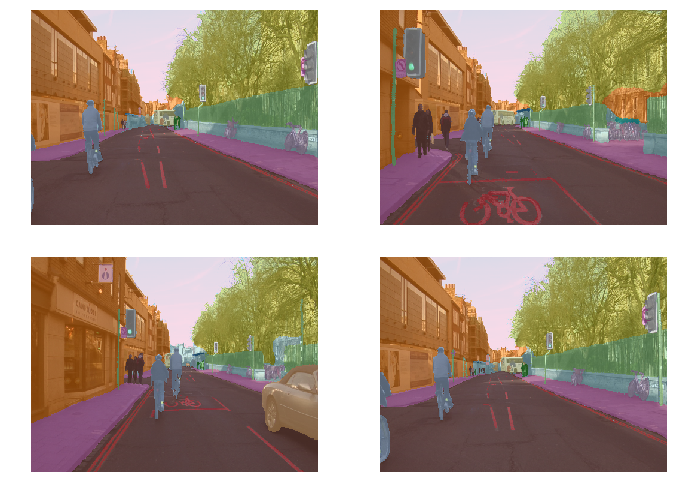

In [23]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

## Build Model

In [0]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id["Void"]

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
wd = 1e-2

In [28]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 92210149.73it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


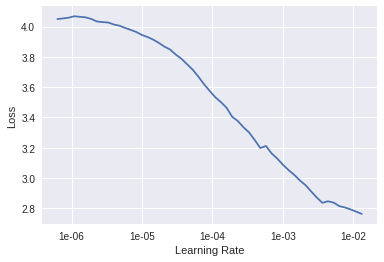

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3e-3

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.302074,0.884238,0.795710,03:57
1,0.870661,0.645320,0.836966,03:48
2,0.713491,0.574067,0.849489,03:47
3,0.621093,0.517864,0.866405,03:47
4,0.617371,0.623525,0.845858,03:46
5,0.614322,0.502322,0.857086,03:45
6,0.588728,0.552946,0.871676,03:44
7,0.597219,0.425367,0.883497,03:43
8,0.514108,0.418946,0.885107,03:43
9,0.450417,0.331876,0.896967,03:43


In [0]:
learn.save("stage-1")

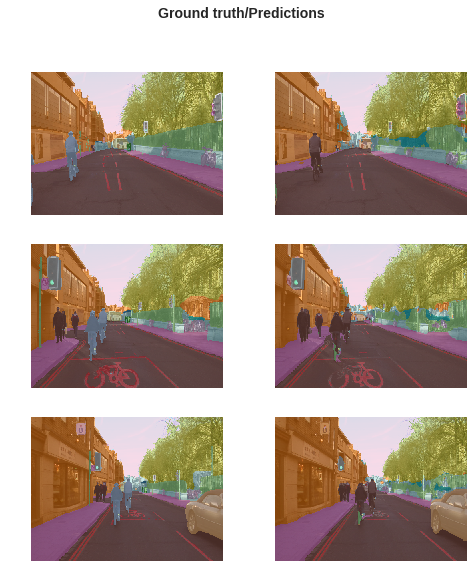

In [34]:
learn.show_results(rows=3, figsize=(8, 9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.379904,0.319771,0.900023,03:53
1,0.369958,0.311599,0.903205,03:52
2,0.357661,0.302162,0.915647,03:53
3,0.352250,0.292132,0.919562,03:52
4,0.347260,0.280080,0.922968,03:51
5,0.335030,0.310736,0.919454,03:51
6,0.329350,0.294487,0.918994,03:53
7,0.323222,0.285371,0.922718,03:53
8,0.308914,0.300461,0.918041,03:51
9,0.304458,0.279108,0.924641,03:51


In [0]:
learn.save("stage-2")

## Go big

In [53]:
size = src_size

free_memory = gpu_mem_get_free_no_cache()

if free_memory > 9000: bs = 3
else:                  bs = 1

print(f"using bs={bs}, have {free_memory}MB of GPU RAM free")

using bs=1, have 474MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [62]:
learn.destroy()
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)

this Learner object self-destroyed - it still exists, but no longer usable


In [63]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


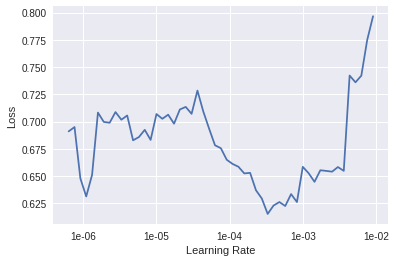

In [61]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
lr = 1e-3

In [66]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.367671,0.281095,0.923598,16:26


KeyboardInterrupt: ignored

In [0]:
learn.save("stage-1-big")

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6, lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save("stage-2-big")

In [0]:
learn.show_results(rows-3, figsize=(10, 10))

## Fin

In [67]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 360, 480]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 360, 480]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 360, 480]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 180, 240]    0          False     
______________________________________________________________________
Conv2d               [1, 64, 180, 240]    36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 180, 240]    0          False     
______________________________________________________________